# 05 — Analyse descriptive (figures pour rapport)
Ce notebook produit des **figures interprétables** (saisonnalité mensuelle, profils journaliers moyens). Ces graphiques sont destinés à être réutilisés dans un rapport/soutenance.


## Sommaire

<details open>
<summary>Afficher / masquer</summary>

- [Paramètres](#parametres)
- [1) Saisonnalité mensuelle (boxplots)](#1-saisonnalite-mensuelle-boxplots)
- [2) Profils moyens par jour de la semaine](#2-profils-moyens-par-jour-de-la-semaine)
- [3) Tendance globale de la consommation électrique](#3-tendance-globale-de-la-consommation-electrique)
- [Interprétation (à compléter)](#interpretation-a-completer)
- [Comparaison qualitative des modèles – semaines représentatives (hiver / été)](#comparaison-qualitative-des-modeles-semaines-representatives-hiver-ete)

</details>


In [3]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")


Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path('.').resolve()
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_FIG = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_FIG.mkdir(parents=True, exist_ok=True)

PATH = DATA_PROCESSED / 'consommation_clean.parquet'
assert PATH.exists(), f'Fichier introuvable: {PATH}'

df = pd.read_parquet(PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,datetime,load_mw
0,2010-01-01 00:00:00,53067
1,2010-01-01 00:30:00,52303
2,2010-01-01 01:00:00,52272
3,2010-01-01 01:30:00,52013
4,2010-01-01 02:00:00,52099


## Paramètres
<a id="parametres"></a>



In [5]:
YEAR = 2010  # changer ici si besoin
df_y = df[df['datetime'].dt.year == YEAR].copy()
df_y.shape, df_y['datetime'].min(), df_y['datetime'].max()

((17520, 2),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-12-31 23:30:00'))

<a id="1-saisonnalite-mensuelle-boxplots"></a>
## 1) Saisonnalité mensuelle (boxplots)





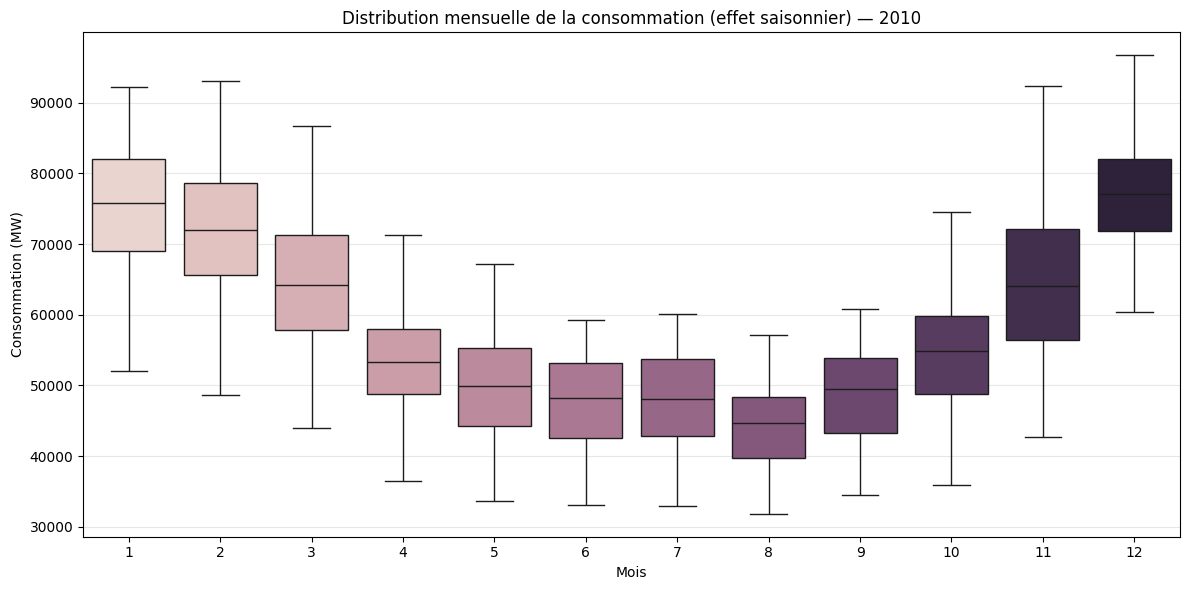

In [6]:
df_y['month'] = df_y['datetime'].dt.month

plt.figure(figsize=(12,6))
# seaborn: palette sans hue -> warning futur, donc on force hue=month et legend=False
sns.boxplot(data=df_y, x='month', y='load_mw', hue='month', legend=False)
plt.title(f'Distribution mensuelle de la consommation (effet saisonnier) — {YEAR}')
plt.xlabel('Mois')
plt.ylabel('Consommation (MW)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_FIG / f'saisonnalite_mensuelle_{YEAR}.png', dpi=150)
plt.show()

## 2) Profils moyens par jour de la semaine

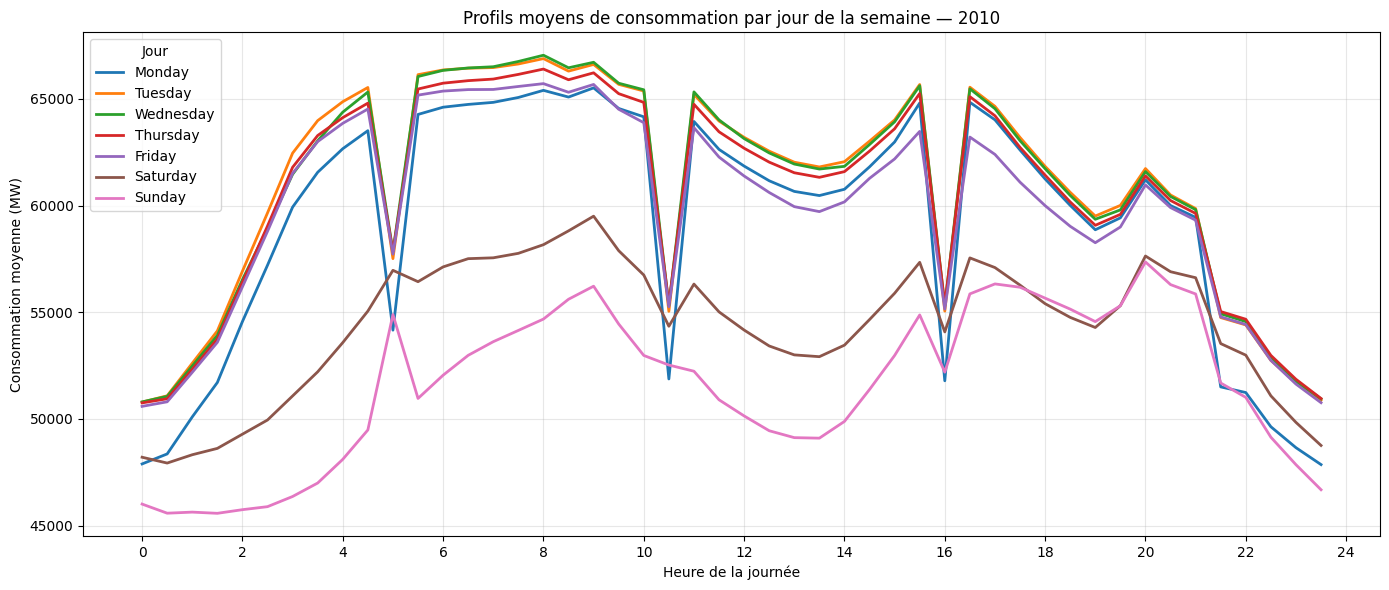

In [15]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_y['day_name'] = pd.Categorical(
    df_y['datetime'].dt.day_name(),
    categories=days_order,
    ordered=True
)

df_y['hour_float'] = df_y['datetime'].dt.hour + df_y['datetime'].dt.minute / 60

daily_profile = (
    df_y.groupby(['day_name', 'hour_float'], observed=True)['load_mw']
       .mean()
       .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=daily_profile,
    x='hour_float',
    y='load_mw',
    hue='day_name',
    linewidth=2
)
plt.title(f'Profils moyens de consommation par jour de la semaine — {YEAR}')
plt.xlabel('Heure de la journée')
plt.ylabel('Consommation moyenne (MW)')
plt.xticks(range(0, 25, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='Jour', loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUT_FIG / f'profils_hebdomadaires_{YEAR}.png', dpi=150)
plt.show()

## 3) Tendance globale de la consommation éléctrique


In [17]:

df_2010 = df[df["datetime"].dt.year == 2010].copy()

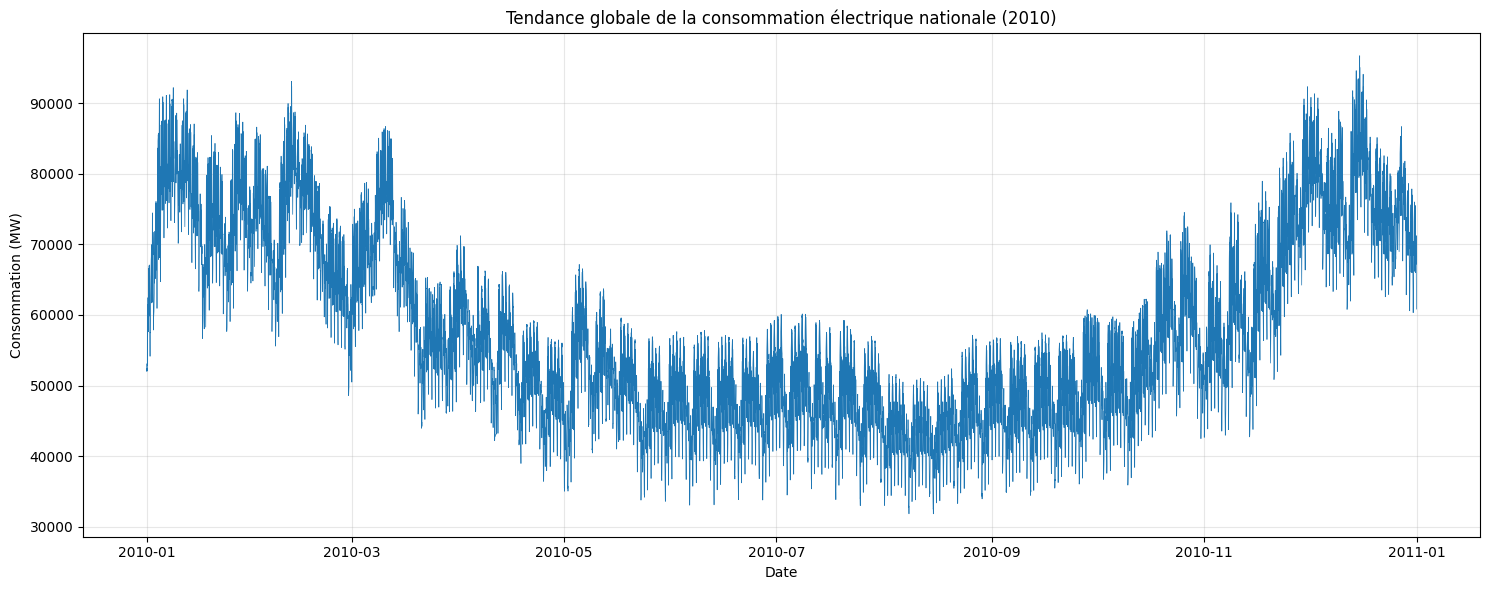

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(df_2010["datetime"], df_2010["load_mw"], linewidth=0.5)

plt.title("Tendance globale de la consommation électrique nationale (2010)")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("tendance_globale.png")
plt.show()

## Interprétation (à compléter)
- Saisonnalité: niveaux plus élevés en hiver, plus bas en été.
- Effet jour de semaine: jours ouvrés > week-end, avec profils intrajournaliers distincts.


## Comparaison qualitative des modèles – semaines représentatives (hiver / été)


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test range: 2021-01-08 00:00:00 → 2022-12-31 23:00:00


13:28:39 - cmdstanpy - INFO - Chain [1] start processing
13:29:54 - cmdstanpy - INFO - Chain [1] done processing


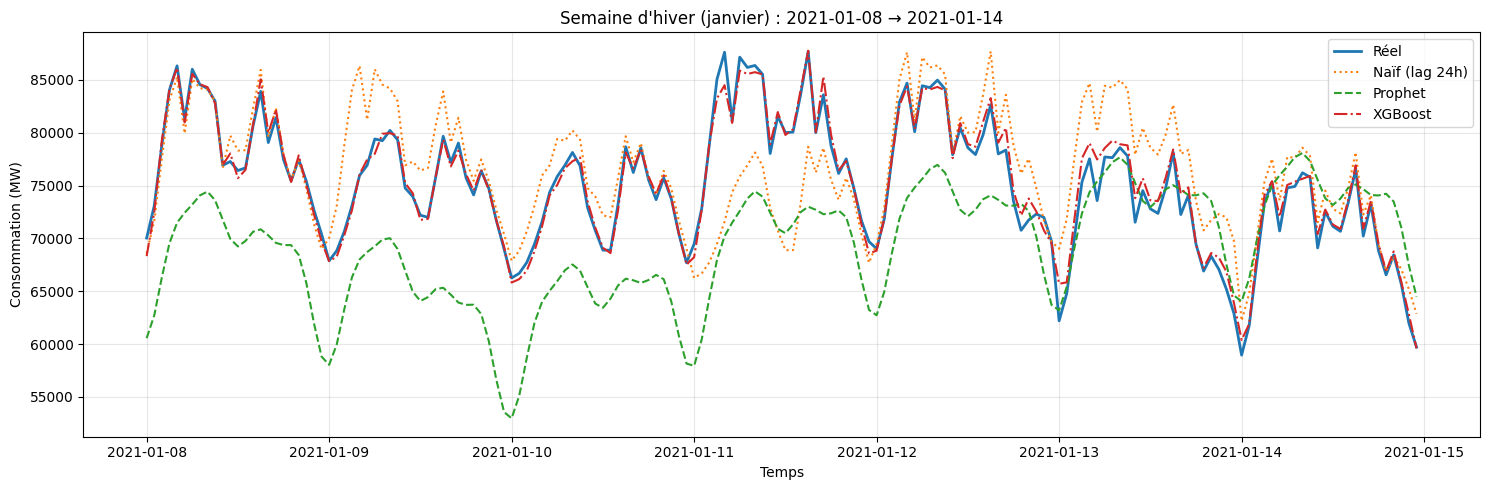

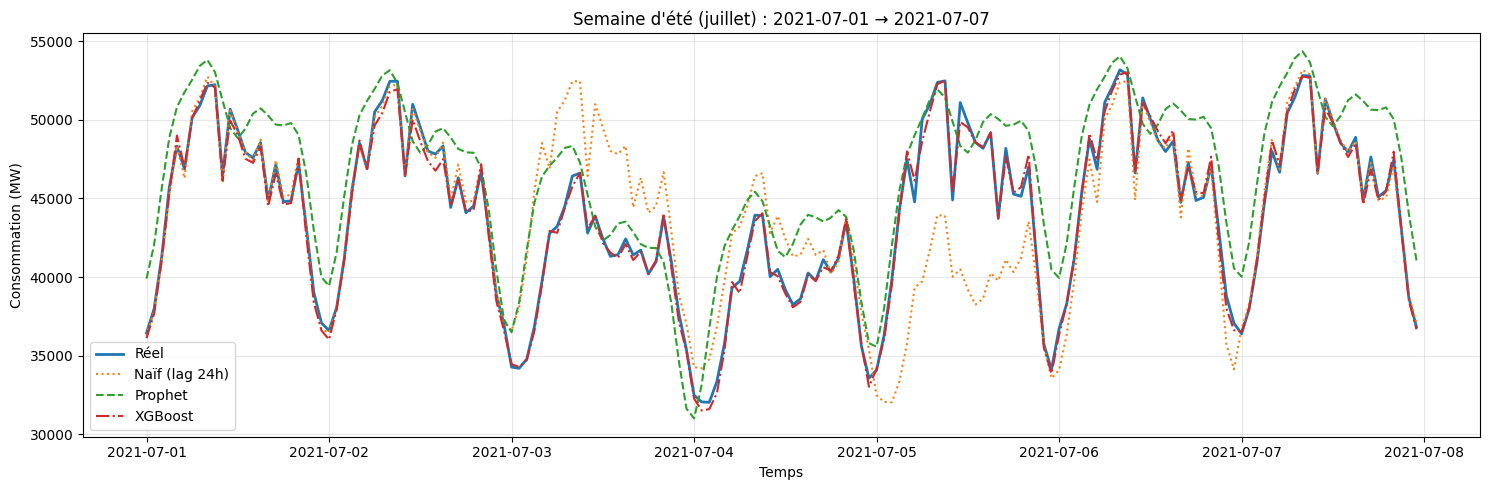

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from prophet import Prophet


# -----------------------------
# 0) Load features dataset (choose baseline or prophetfilled)
# -----------------------------
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "dataset_features.parquet"
# FEATURES_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df = pd.read_parquet(FEATURES_PATH).copy()
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

TARGET = "y"
META_COLS = ["datetime", "split"]

# Naive needs this column
assert "load_lag_24h" in df.columns, "Missing feature 'load_lag_24h' for naive baseline."
assert TARGET in df.columns, f"Missing target '{TARGET}'."

FEATURES = [c for c in df.columns if c not in META_COLS + [TARGET]]

train = df[df["split"] == "train"].copy()
test  = df[df["split"] == "test"].copy()

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print("Test range:", test["datetime"].min(), "→", test["datetime"].max())


# -----------------------------
# 1) Train XGBoost and predict on test
# -----------------------------
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)


# -----------------------------
# 2) Train Prophet (univariate) and predict on test datetimes
# -----------------------------
prophet_train = train[["datetime", "y"]].rename(columns={"datetime": "ds", "y": "y"})
prophet_test_ds = test[["datetime"]].rename(columns={"datetime": "ds"})

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_train)

forecast = m.predict(prophet_test_ds)
pred_prophet = forecast["yhat"].values


# -----------------------------
# 3) Build a single aligned dataframe for plotting
# -----------------------------
plot_all = test[["datetime", "y", "load_lag_24h"]].copy()
plot_all["pred_naive"] = plot_all["load_lag_24h"].astype(float)
plot_all["pred_prophet"] = pred_prophet
plot_all["pred_xgb"] = pred_xgb


# -----------------------------
# 4) Helper: pick a valid week inside test for a given month (Jan / Jul)
# -----------------------------
def select_week_in_month(df_plot: pd.DataFrame, month: int, days: int = 7) -> tuple[pd.Timestamp, pd.Timestamp, pd.DataFrame]:
    dfi = df_plot[df_plot["datetime"].dt.month == month].copy()
    if dfi.empty:
        raise ValueError(f"No data for month={month} in test set.")
    start = dfi["datetime"].min().normalize()
    end = start + pd.Timedelta(days=days)
    week = df_plot[(df_plot["datetime"] >= start) & (df_plot["datetime"] < end)].copy()
    if week.empty:
        raise ValueError(f"Week selection failed for month={month}.")
    return start, end, week


def plot_week(week: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 5))
    plt.plot(week["datetime"], week["y"], label="Réel", linewidth=2)
    plt.plot(week["datetime"], week["pred_naive"], label="Naïf (lag 24h)", linestyle=":")
    plt.plot(week["datetime"], week["pred_prophet"], label="Prophet", linestyle="--")
    plt.plot(week["datetime"], week["pred_xgb"], label="XGBoost", linestyle="-.")
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Consommation (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 5) Plot one winter week (January) and one summer week (July)
# -----------------------------
start_jan, end_jan, week_jan = select_week_in_month(plot_all, month=1, days=7)
plot_week(week_jan, f"Semaine d'hiver (janvier) : {start_jan.date()} → {(end_jan - pd.Timedelta(days=1)).date()}")

start_jul, end_jul, week_jul = select_week_in_month(plot_all, month=7, days=7)
plot_week(week_jul, f"Semaine d'été (juillet) : {start_jul.date()} → {(end_jul - pd.Timedelta(days=1)).date()}")


Test range: 2021-01-08 00:00:00 → 2022-12-31 23:00:00


13:31:02 - cmdstanpy - INFO - Chain [1] start processing
13:32:13 - cmdstanpy - INFO - Chain [1] done processing


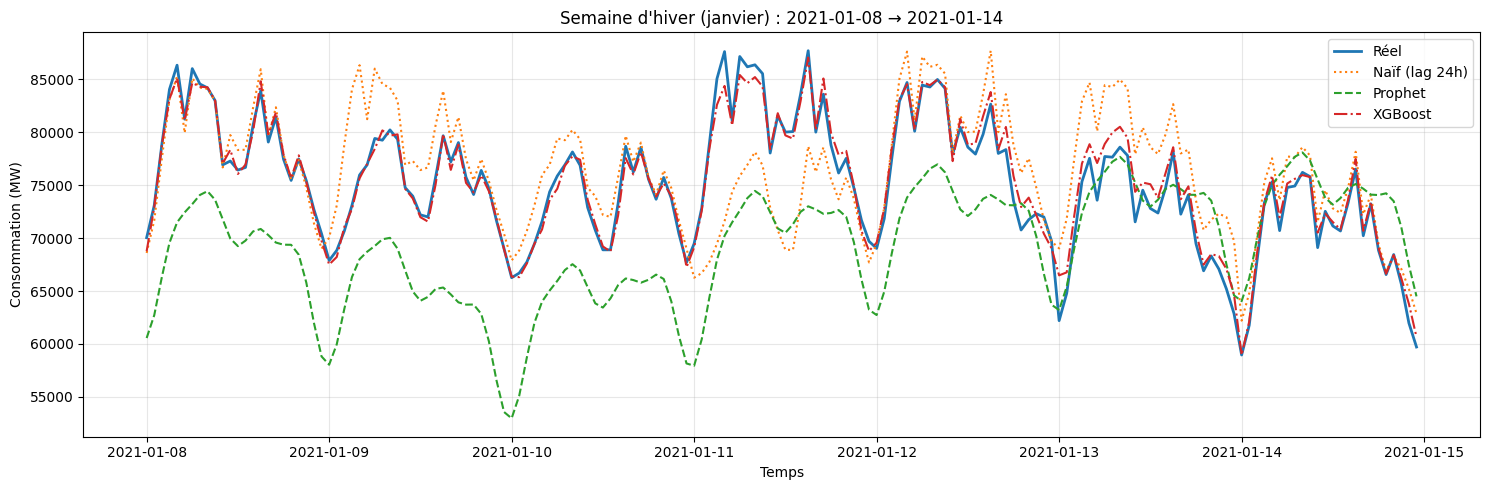

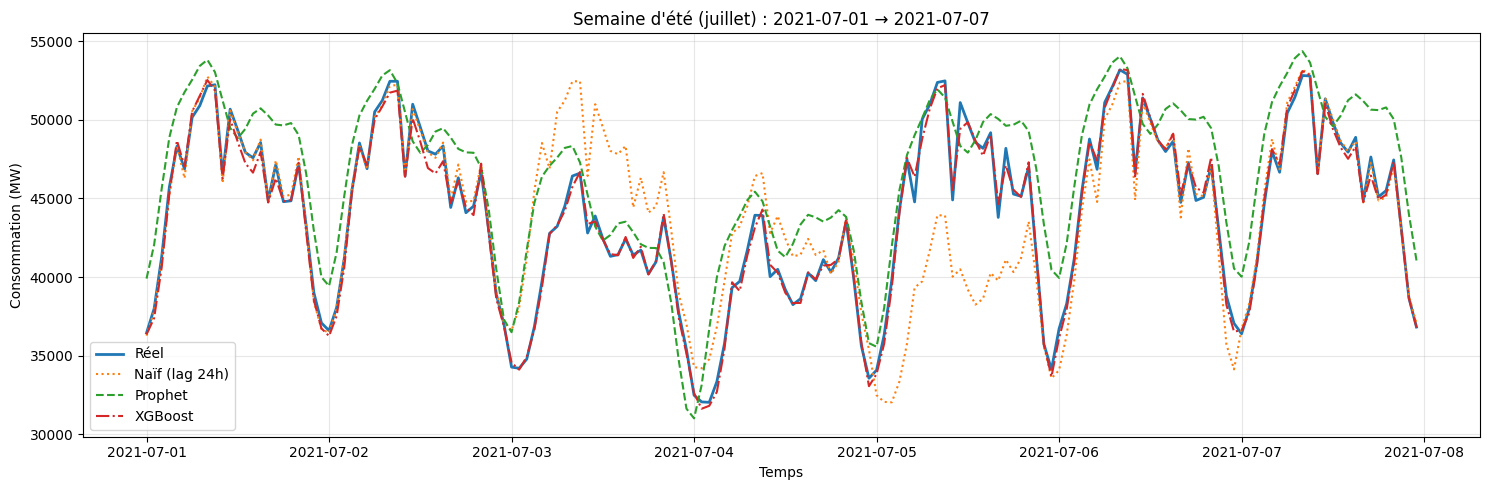

NameError: name 'v' is not defined

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from prophet import Prophet


# -----------------------------
# 0) Load features dataset (choose baseline or prophetfilled)
# -----------------------------
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "dataset_features.parquet"
# FEATURES_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df = pd.read_parquet(FEATURES_PATH).copy()
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

TARGET = "y"
META_COLS = ["datetime", "split"]

# Naive needs this column
assert "load_lag_24h" in df.columns, "Missing feature 'load_lag_24h' for naive baseline."
assert TARGET in df.columns, f"Missing target '{TARGET}'."

FEATURES = [c for c in df.columns if c not in META_COLS + [TARGET]]

train = df[df["split"] == "train"].copy()
test  = df[df["split"] == "test"].copy()

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print("Test range:", test["datetime"].min(), "→", test["datetime"].max())


# -----------------------------
# 1) Train XGBoost and predict on test
# -----------------------------
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)


# -----------------------------
# 2) Train Prophet (univariate) and predict on test datetimes
# -----------------------------
prophet_train = train[["datetime", "y"]].rename(columns={"datetime": "ds", "y": "y"})
prophet_test_ds = test[["datetime"]].rename(columns={"datetime": "ds"})

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_train)

forecast = m.predict(prophet_test_ds)
pred_prophet = forecast["yhat"].values


# -----------------------------
# 3) Build a single aligned dataframe for plotting
# -----------------------------
plot_all = test[["datetime", "y", "load_lag_24h"]].copy()
plot_all["pred_naive"] = plot_all["load_lag_24h"].astype(float)
plot_all["pred_prophet"] = pred_prophet
plot_all["pred_xgb"] = pred_xgb


# -----------------------------
# 4) Helper: pick a valid week inside test for a given month (Jan / Jul)
# -----------------------------
def select_week_in_month(df_plot: pd.DataFrame, month: int, days: int = 7) -> tuple[pd.Timestamp, pd.Timestamp, pd.DataFrame]:
    dfi = df_plot[df_plot["datetime"].dt.month == month].copy()
    if dfi.empty:
        raise ValueError(f"No data for month={month} in test set.")
    start = dfi["datetime"].min().normalize()
    end = start + pd.Timedelta(days=days)
    week = df_plot[(df_plot["datetime"] >= start) & (df_plot["datetime"] < end)].copy()
    if week.empty:
        raise ValueError(f"Week selection failed for month={month}.")
    return start, end, week


def plot_week(week: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 5))
    plt.plot(week["datetime"], week["y"], label="Réel", linewidth=2)
    plt.plot(week["datetime"], week["pred_naive"], label="Naïf (lag 24h)", linestyle=":")
    plt.plot(week["datetime"], week["pred_prophet"], label="Prophet", linestyle="--")
    plt.plot(week["datetime"], week["pred_xgb"], label="XGBoost", linestyle="-.")
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Consommation (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 5) Plot one winter week (January) and one summer week (July)
# -----------------------------
start_jan, end_jan, week_jan = select_week_in_month(plot_all, month=1, days=7)
plot_week(week_jan, f"Semaine d'hiver (janvier) : {start_jan.date()} → {(end_jan - pd.Timedelta(days=1)).date()}")

start_jul, end_jul, week_jul = select_week_in_month(plot_all, month=7, days=7)
plot_week(week_jul, f"Semaine d'été (juillet) : {start_jul.date()} → {(end_jul - pd.Timedelta(days=1)).date()}")
v

Les figures ci-dessus comparent, sur deux semaines représentatives de l’échantillon
de test (janvier 2021 et juillet 2021), les prédictions de quatre approches :
un modèle naïf (retard de 24 heures), Prophet, XGBoost et la consommation observée.

En hiver, la consommation est marquée par des niveaux élevés et de fortes pointes
journalières. Le modèle naïf reproduit correctement la structure horaire générale
mais présente des décalages systématiques, notamment lors des variations rapides.
Le modèle Prophet génère des prédictions fortement lissées et sous-estime les pics
de consommation, ce qui traduit une incapacité à capturer la dynamique horaire fine.
À l’inverse, XGBoost suit étroitement la série observée, tant en niveau qu’en amplitude,
et reproduit fidèlement les pointes du matin et du soir.

En été, la consommation est plus faible et dominée par un cycle journalier régulier.
Le modèle naïf reste compétitif lorsque la dynamique est stable, mais échoue lors des
changements de régime. Prophet tend ici à surestimer certaines périodes et à lisser
excessivement les creux, ce qui conduit à des écarts importants avec la série réelle.
XGBoost conserve de bonnes performances, capturant à la fois les creux nocturnes et
les hausses diurnes, y compris lors des journées plus atypiques.

Ces comparaisons qualitatives confirment les résultats quantitatifs obtenus précédemment :
les modèles linéaires et Prophet restent limités par leurs hypothèses structurelles,
tandis que XGBoost bénéficie pleinement des variables explicatives et des relations
non linéaires pour modéliser la consommation électrique horaire.
